# NBA Game Winner Classifier - Preliminar

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
import dataframe_image as dfi

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [3]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [4]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [5]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [6]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [7]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [9]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [10]:
season_games = sg.load_season_games_dataset()

## Dataset


In [179]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [11]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

### Clean data

In [12]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)
utils.serialize_object('df', df)

(9599, 405)
0
(9461, 405)
(8372, 405)


In [59]:
pd.set_option('display.max_rows', 600)
df_styled = df[model_config.X_COLS_NO_HIGH_CORR].head(5)
to_image = df_styled.T
dfi.export(to_image, 'preliminar_first_5_games.png', max_rows=-1)

df_styled = df[model_config.X_COLS_NO_HIGH_CORR].tail(5)
to_image = df_styled.T
dfi.export(to_image, 'preliminar_last_5_games.png', max_rows=-1)

## Experiments

### Setup

In [13]:
exp_prefix = "clf_"
exp_group_name = "clf_experiments"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"

exp_X_columns = model_config.X_COLS_NO_HIGH_CORR
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Experiment using 1 season

In [46]:
experiment_name = f"{exp_prefix}1_season"

In [47]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
1,clf_1_season,KNN,0.684483,0.027233,0.625446,0.019096
4,clf_1_season,RF,0.682557,0.032009,0.631856,0.024542
0,clf_1_season,L2R,0.666104,0.034095,0.609949,0.023001
6,clf_1_season,XGB,0.660354,0.033241,0.602931,0.028432
5,clf_1_season,LGB,0.659121,0.033261,0.603175,0.025420
3,clf_1_season,SVM,0.657665,0.035468,0.599357,0.024101
2,clf_1_season,DT,0.644409,0.030753,0.575132,0.028588


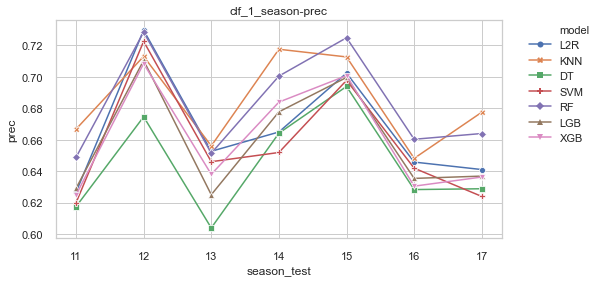

In [48]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [49]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1077,11,838
1,11,838,12,1078
2,12,1078,13,1076
3,13,1076,14,1075
4,14,1075,15,1076
5,15,1076,16,1075
6,16,1075,17,1077


### Experiment using StandardScaler

In [50]:
# experiment_name = f"{exp_prefix}scaled_data"

In [51]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
11,clf_scaled_data,RF,0.682070,0.032275,0.631216,0.023673
8,clf_scaled_data,KNN,0.675491,0.034029,0.616276,0.023942
13,clf_scaled_data,XGB,0.660286,0.033302,0.602817,0.028562
7,clf_scaled_data,L2R,0.658817,0.031629,0.598986,0.018980
12,clf_scaled_data,LGB,0.658190,0.032449,0.602887,0.027819
10,clf_scaled_data,SVM,0.653143,0.033928,0.591733,0.021153
9,clf_scaled_data,DT,0.643869,0.031111,0.574438,0.029023


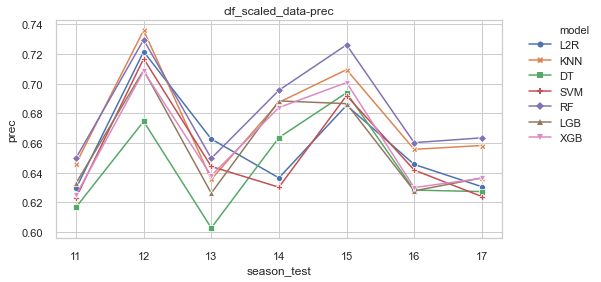

In [52]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))


In [53]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1077,11,838
1,11,838,12,1078
2,12,1078,13,1076
3,13,1076,14,1075
4,14,1075,15,1076
5,15,1076,16,1075
6,16,1075,17,1077


### Experiment using MinMaxScaler

In [54]:
# experiment_name = f"{exp_prefix}minmax_data"

In [55]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
18,clf_minmax_data,RF,0.681411,0.032222,0.630500,0.024092
15,clf_minmax_data,KNN,0.677922,0.029985,0.618850,0.021041
14,clf_minmax_data,L2R,0.665775,0.030697,0.612058,0.018699
17,clf_minmax_data,SVM,0.661336,0.030598,0.605329,0.017672
20,clf_minmax_data,XGB,0.660083,0.033313,0.602603,0.028543
19,clf_minmax_data,LGB,0.655596,0.032395,0.598340,0.027333
16,clf_minmax_data,DT,0.644404,0.030904,0.575131,0.028856


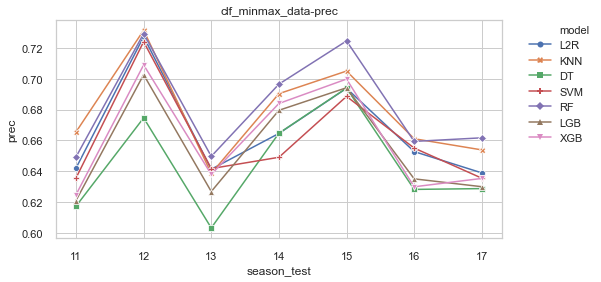

In [56]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))

In [57]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1077,11,838
1,11,838,12,1078
2,12,1078,13,1076
3,13,1076,14,1075
4,14,1075,15,1076
5,15,1076,16,1075
6,16,1075,17,1077


### Experiment: train: 2s; test: 1s

In [58]:
experiment_name = f"{exp_prefix}2_seasons"

In [59]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment clf_2_seasons
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
22,clf_2_seasons,KNN,0.684692,0.026786,0.626506,0.021991
21,clf_2_seasons,L2R,0.684436,0.039964,0.633346,0.030528
25,clf_2_seasons,RF,0.682227,0.022373,0.632720,0.018689
24,clf_2_seasons,SVM,0.680295,0.035101,0.627470,0.025292
26,clf_2_seasons,LGB,0.667996,0.024018,0.614668,0.024154
27,clf_2_seasons,XGB,0.666634,0.027256,0.610317,0.020756
23,clf_2_seasons,DT,0.635555,0.023180,0.559553,0.014746


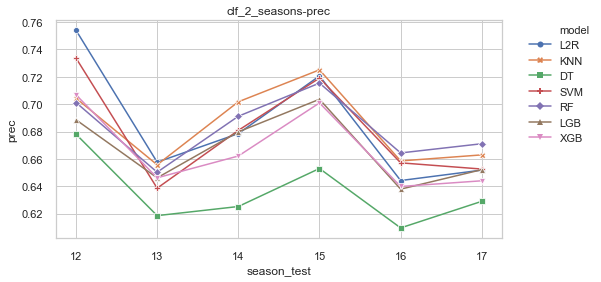

In [60]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [61]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11,1915,12,1078
1,11-12,1916,13,1076
2,12-13,2154,14,1075
3,13-14,2151,15,1076
4,14-15,2151,16,1075
5,15-16,2151,17,1077


### Experiment: train: 3s; test: 1s

In [62]:
experiment_name = f"{exp_prefix}3_seasons"

In [63]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
32,clf_3_seasons,RF,0.678424,0.021258,0.634084,0.020115
29,clf_3_seasons,KNN,0.676875,0.022163,0.623985,0.022465
31,clf_3_seasons,SVM,0.676084,0.026471,0.632159,0.025478
28,clf_3_seasons,L2R,0.675976,0.026085,0.633495,0.026076
33,clf_3_seasons,LGB,0.669303,0.016110,0.623403,0.014920
34,clf_3_seasons,XGB,0.665649,0.017194,0.616520,0.018059
30,clf_3_seasons,DT,0.641888,0.033427,0.571177,0.032502


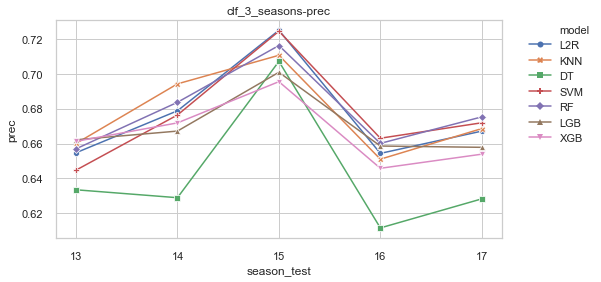

In [64]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [65]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11-12,2993,13,1076
1,11-12-13,2992,14,1075
2,12-13-14,3229,15,1076
3,13-14-15,3227,16,1075
4,14-15-16,3226,17,1077


### Experiment remove last 2q ; train: 2q ; test: 2q

In [66]:
experiment_name = f"{exp_prefix}2q_2q_rl2q"

In [67]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_rl2q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
36,clf_2q_2q_rl2q,KNN,0.666448,0.039134,0.613568,0.025811
39,clf_2q_2q_rl2q,RF,0.659288,0.041096,0.611928,0.031792
35,clf_2q_2q_rl2q,L2R,0.652075,0.043689,0.597168,0.027320
41,clf_2q_2q_rl2q,XGB,0.644621,0.043001,0.589987,0.023726
38,clf_2q_2q_rl2q,SVM,0.641231,0.042220,0.582965,0.033557
40,clf_2q_2q_rl2q,LGB,0.638726,0.047444,0.584230,0.027653
37,clf_2q_2q_rl2q,DT,0.619313,0.037805,0.553689,0.024470


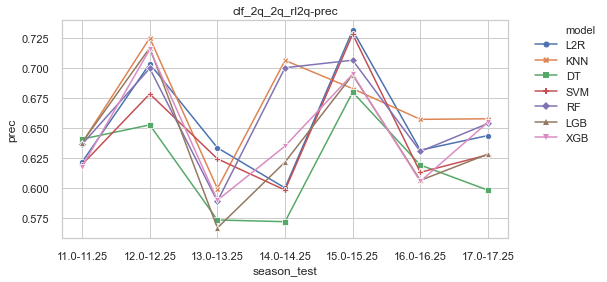

In [68]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [69]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25,538,11.0-11.25,419
1,11.0-11.25,419,12.0-12.25,539
2,12.0-12.25,539,13.0-13.25,538
3,13.0-13.25,538,14.0-14.25,537
4,14.0-14.25,537,15.0-15.25,538
5,15.0-15.25,538,16.0-16.25,537
6,16.0-16.25,537,17.0-17.25,538


### Experiment remove first 2q ;train: 2q ; test: 2q

In [70]:
experiment_name = f"{exp_prefix}2q_2q_rf2q"

In [71]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_rf2q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
43,clf_2q_2q_rf2q,KNN,0.708542,0.029431,0.644783,0.028211
46,clf_2q_2q_rf2q,RF,0.706045,0.030783,0.650138,0.026285
48,clf_2q_2q_rf2q,XGB,0.692893,0.022986,0.629086,0.018744
42,clf_2q_2q_rf2q,L2R,0.686775,0.037995,0.615027,0.032376
45,clf_2q_2q_rf2q,SVM,0.680159,0.028689,0.606057,0.028627
47,clf_2q_2q_rf2q,LGB,0.677820,0.016268,0.614824,0.012588
44,clf_2q_2q_rf2q,DT,0.655557,0.007718,0.570012,0.015696


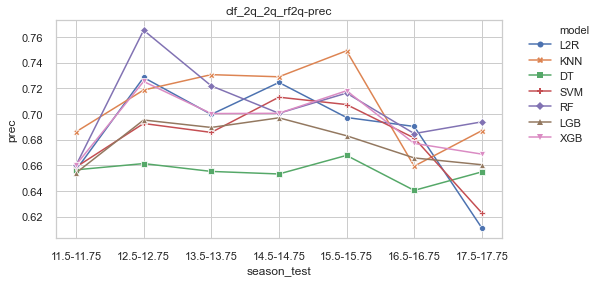

In [72]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [73]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75,539,11.5-11.75,419
1,11.5-11.75,419,12.5-12.75,539
2,12.5-12.75,539,13.5-13.75,538
3,13.5-13.75,538,14.5-14.75,538
4,14.5-14.75,538,15.5-15.75,538
5,15.5-15.75,538,16.5-16.75,538
6,16.5-16.75,538,17.5-17.75,539


### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [74]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q"

In [75]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_r1q_s3q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
50,clf_3q_1q_r1q_s3q,KNN,0.666495,0.042650,0.621954,0.029291
53,clf_3q_1q_r1q_s3q,RF,0.657610,0.048607,0.613177,0.047628
49,clf_3q_1q_r1q_s3q,L2R,0.645960,0.045871,0.602187,0.027375
52,clf_3q_1q_r1q_s3q,SVM,0.639356,0.043576,0.595387,0.029753
51,clf_3q_1q_r1q_s3q,DT,0.638039,0.039887,0.579477,0.032570
54,clf_3q_1q_r1q_s3q,LGB,0.637022,0.048267,0.591479,0.031258
55,clf_3q_1q_r1q_s3q,XGB,0.636245,0.046974,0.588285,0.028168


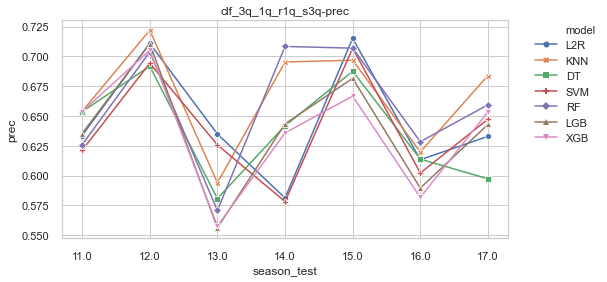

In [76]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [77]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,807,11.0,209
1,11.0-11.25-11.5,628,12.0,269
2,12.0-12.25-12.5,808,13.0,269
3,13.0-13.25-13.5,807,14.0,268
4,14.0-14.25-14.5,806,15.0,269
5,15.0-15.25-15.5,807,16.0,268
6,16.0-16.25-16.5,806,17.0,269


### Experiment train: 3q ; test: 1q ; step: 3q

In [78]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [79]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_3s
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
57,clf_3q_1q_3s,KNN,0.734080,0.034295,0.658122,0.026132
60,clf_3q_1q_3s,RF,0.720423,0.029262,0.657153,0.025716
56,clf_3q_1q_3s,L2R,0.702298,0.037924,0.625891,0.039325
61,clf_3q_1q_3s,LGB,0.701003,0.030558,0.629848,0.045091
62,clf_3q_1q_3s,XGB,0.699929,0.024417,0.624007,0.037747
59,clf_3q_1q_3s,SVM,0.699891,0.038766,0.621828,0.039517
58,clf_3q_1q_3s,DT,0.653516,0.041858,0.564450,0.042167


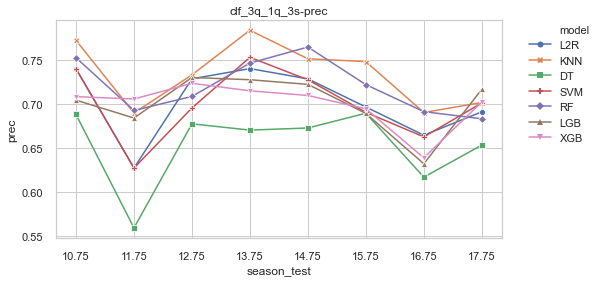

In [80]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [81]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,807,10.75,270
1,11.0-11.25-11.5,628,11.75,210
2,12.0-12.25-12.5,808,12.75,270
3,13.0-13.25-13.5,807,13.75,269
4,14.0-14.25-14.5,806,14.75,269
5,15.0-15.25-15.5,807,15.75,269
6,16.0-16.25-16.5,806,16.75,269
7,17.0-17.25-17.5,807,17.75,270


### Experiment train: 4q ; test: 2q

In [82]:
# experiment_name = f"{exp_prefix}4q_2q"

In [83]:
# del_result_by(experiment_name)

# folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
64,clf_4q_2q,KNN,0.686201,0.043208,0.627250,0.028433
67,clf_4q_2q,RF,0.683647,0.042209,0.634530,0.032507
63,clf_4q_2q,L2R,0.676506,0.049223,0.621944,0.033511
69,clf_4q_2q,XGB,0.668465,0.050708,0.610774,0.040423
68,clf_4q_2q,LGB,0.667608,0.048986,0.611861,0.032738
66,clf_4q_2q,SVM,0.667554,0.045816,0.609311,0.028319
65,clf_4q_2q,DT,0.642207,0.040236,0.568837,0.028774


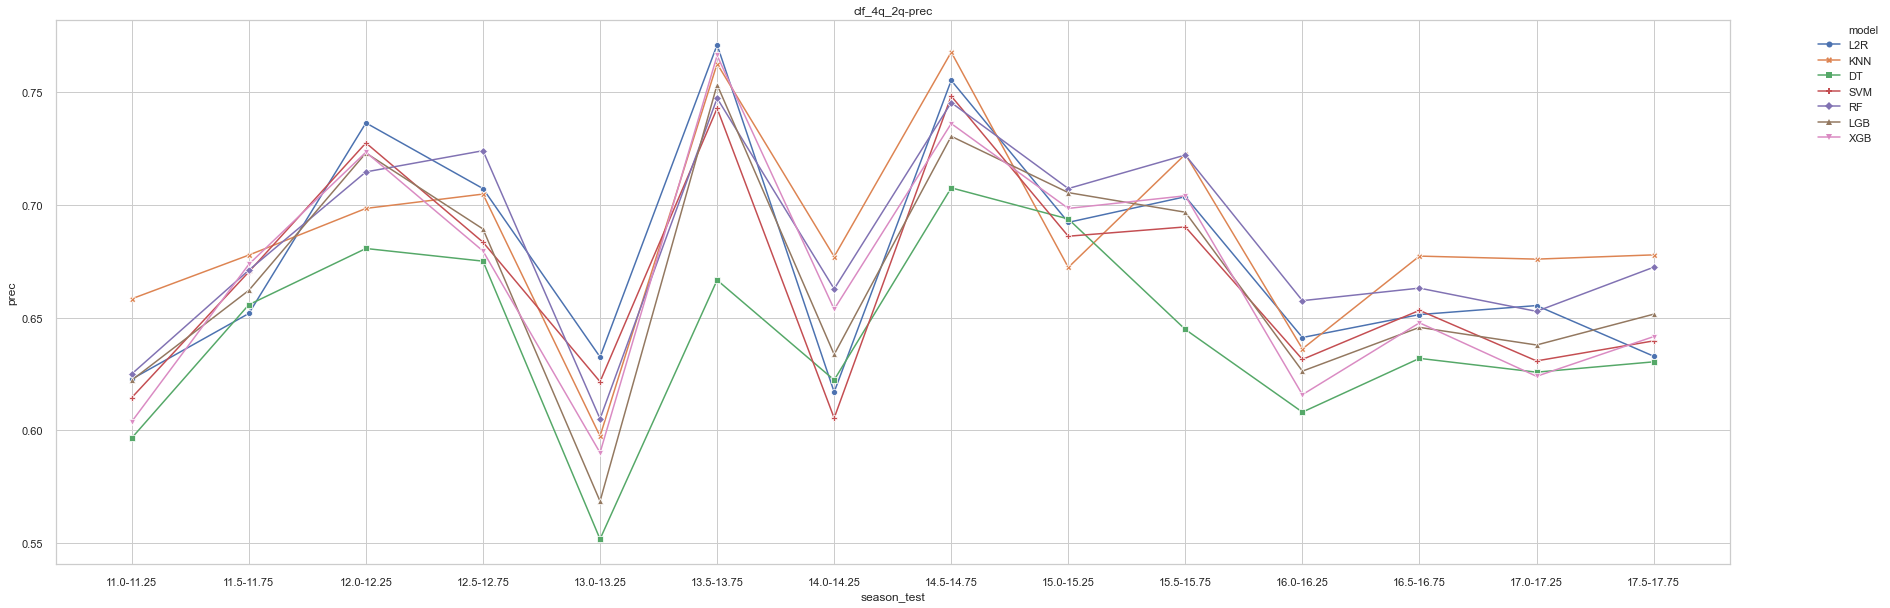

In [84]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(30,10))

In [85]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5-10.75,1077,11.0-11.25,419
1,10.5-10.75-11.0-11.25,958,11.5-11.75,419
2,11.0-11.25-11.5-11.75,838,12.0-12.25,539
3,11.5-11.75-12.0-12.25,958,12.5-12.75,539
4,12.0-12.25-12.5-12.75,1078,13.0-13.25,538
5,12.5-12.75-13.0-13.25,1077,13.5-13.75,538
6,13.0-13.25-13.5-13.75,1076,14.0-14.25,537
7,13.5-13.75-14.0-14.25,1075,14.5-14.75,538
8,14.0-14.25-14.5-14.75,1075,15.0-15.25,538
9,14.5-14.75-15.0-15.25,1076,15.5-15.75,538


### Experiment remove first 2q ; train: 4q ; test: 2q

In [100]:
experiment_name = f"{exp_prefix}4q_2q_rf2q"

In [101]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q_rf2q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
71,clf_4q_2q_rf2q,KNN,0.712712,0.025745,0.646037,0.027462
74,clf_4q_2q_rf2q,RF,0.709438,0.014701,0.653729,0.021303
70,clf_4q_2q_rf2q,L2R,0.706215,0.034781,0.638579,0.027117
73,clf_4q_2q_rf2q,SVM,0.702433,0.034585,0.635187,0.027401
76,clf_4q_2q_rf2q,XGB,0.700360,0.029903,0.638773,0.027068
75,clf_4q_2q_rf2q,LGB,0.692100,0.018309,0.632635,0.013823
72,clf_4q_2q_rf2q,DT,0.661376,0.021299,0.580310,0.019090


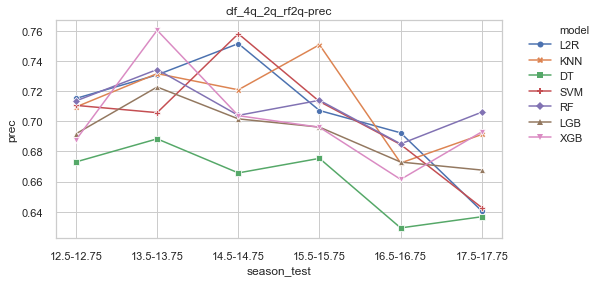

In [102]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [103]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75-11.5-11.75,958,12.5-12.75,539
1,11.5-11.75-12.5-12.75,958,13.5-13.75,538
2,12.5-12.75-13.5-13.75,1077,14.5-14.75,538
3,13.5-13.75-14.5-14.75,1076,15.5-15.75,538
4,14.5-14.75-15.5-15.75,1076,16.5-16.75,538
5,15.5-15.75-16.5-16.75,1076,17.5-17.75,539


### Experiments comparison

In [104]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [105]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [106]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [107]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [108]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:10].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
0,clf_3q_1q_3s,KNN,0.734080,0.034295,0.658122,0.026132
1,clf_3q_1q_3s,RF,0.720423,0.029262,0.657153,0.025716
2,clf_4q_2q_rf2q,KNN,0.712712,0.025745,0.646037,0.027462
3,clf_4q_2q_rf2q,RF,0.709438,0.014701,0.653729,0.021303
4,clf_2q_2q_rf2q,KNN,0.708542,0.029431,0.644783,0.028211
5,clf_4q_2q_rf2q,L2R,0.706215,0.034781,0.638579,0.027117
6,clf_2q_2q_rf2q,RF,0.706045,0.030783,0.650138,0.026285
7,clf_4q_2q_rf2q,SVM,0.702433,0.034585,0.635187,0.027401
8,clf_3q_1q_3s,L2R,0.702298,0.037924,0.625891,0.039325
9,clf_3q_1q_3s,LGB,0.701003,0.030558,0.629848,0.045091


### Plot experiment results

In [95]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

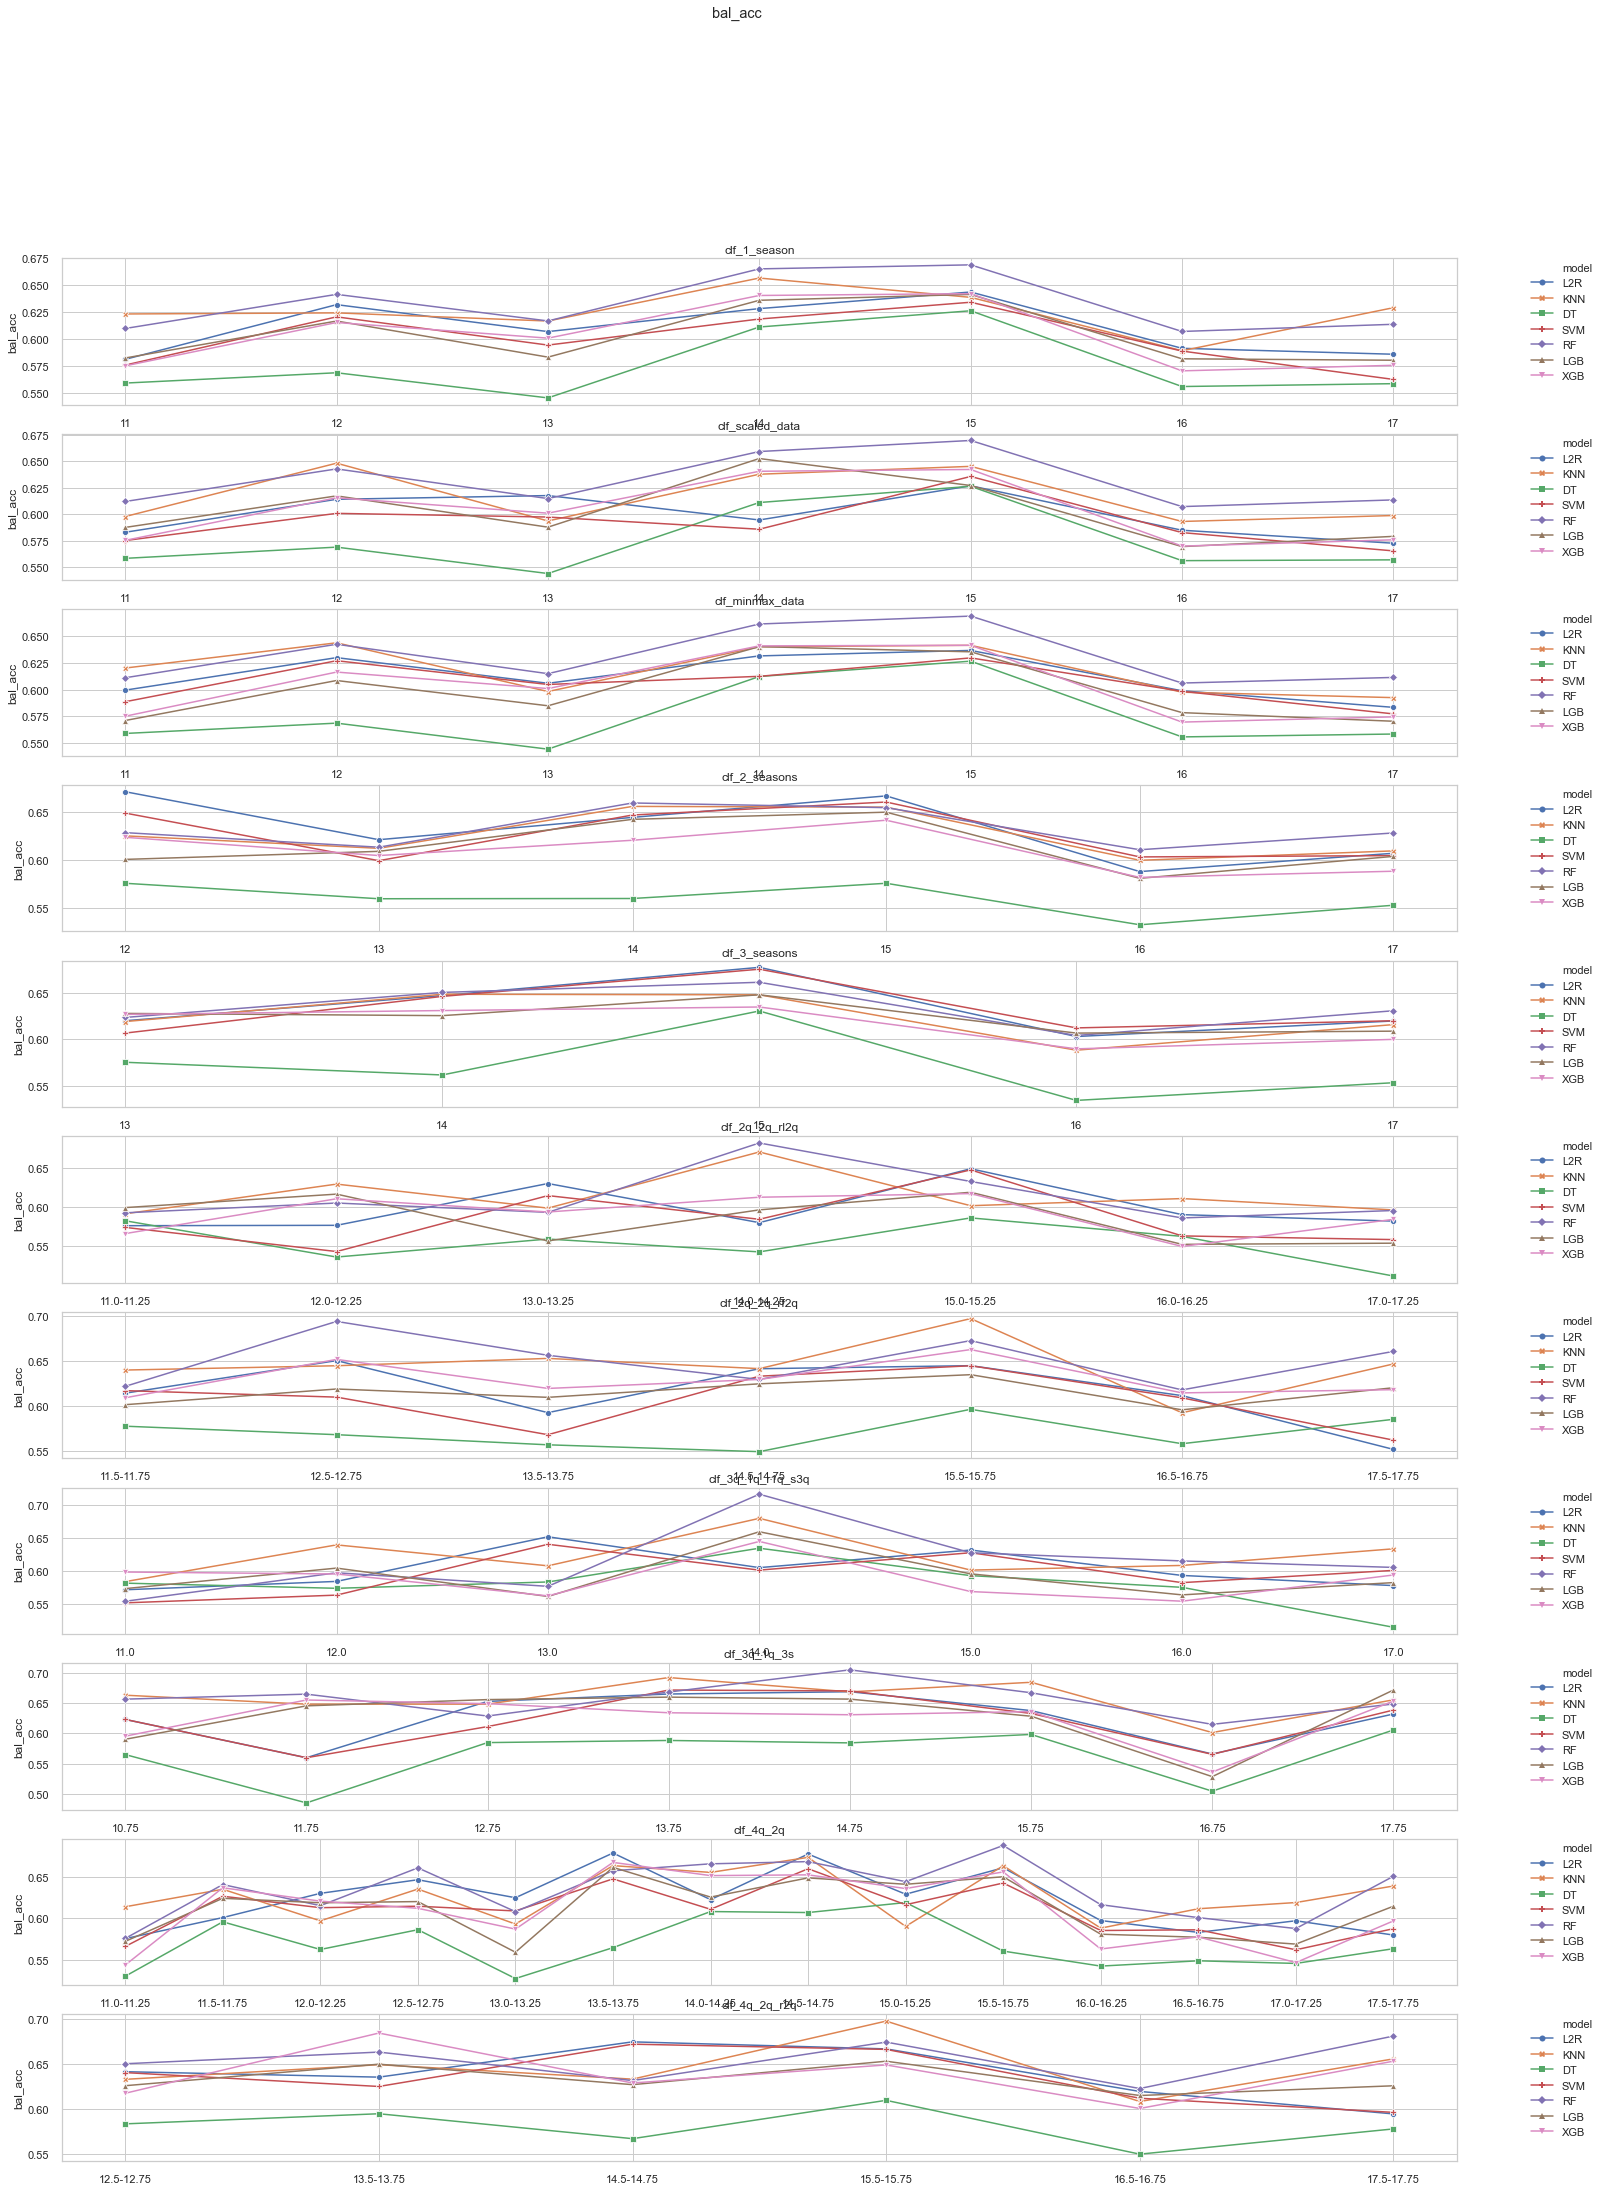

In [96]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

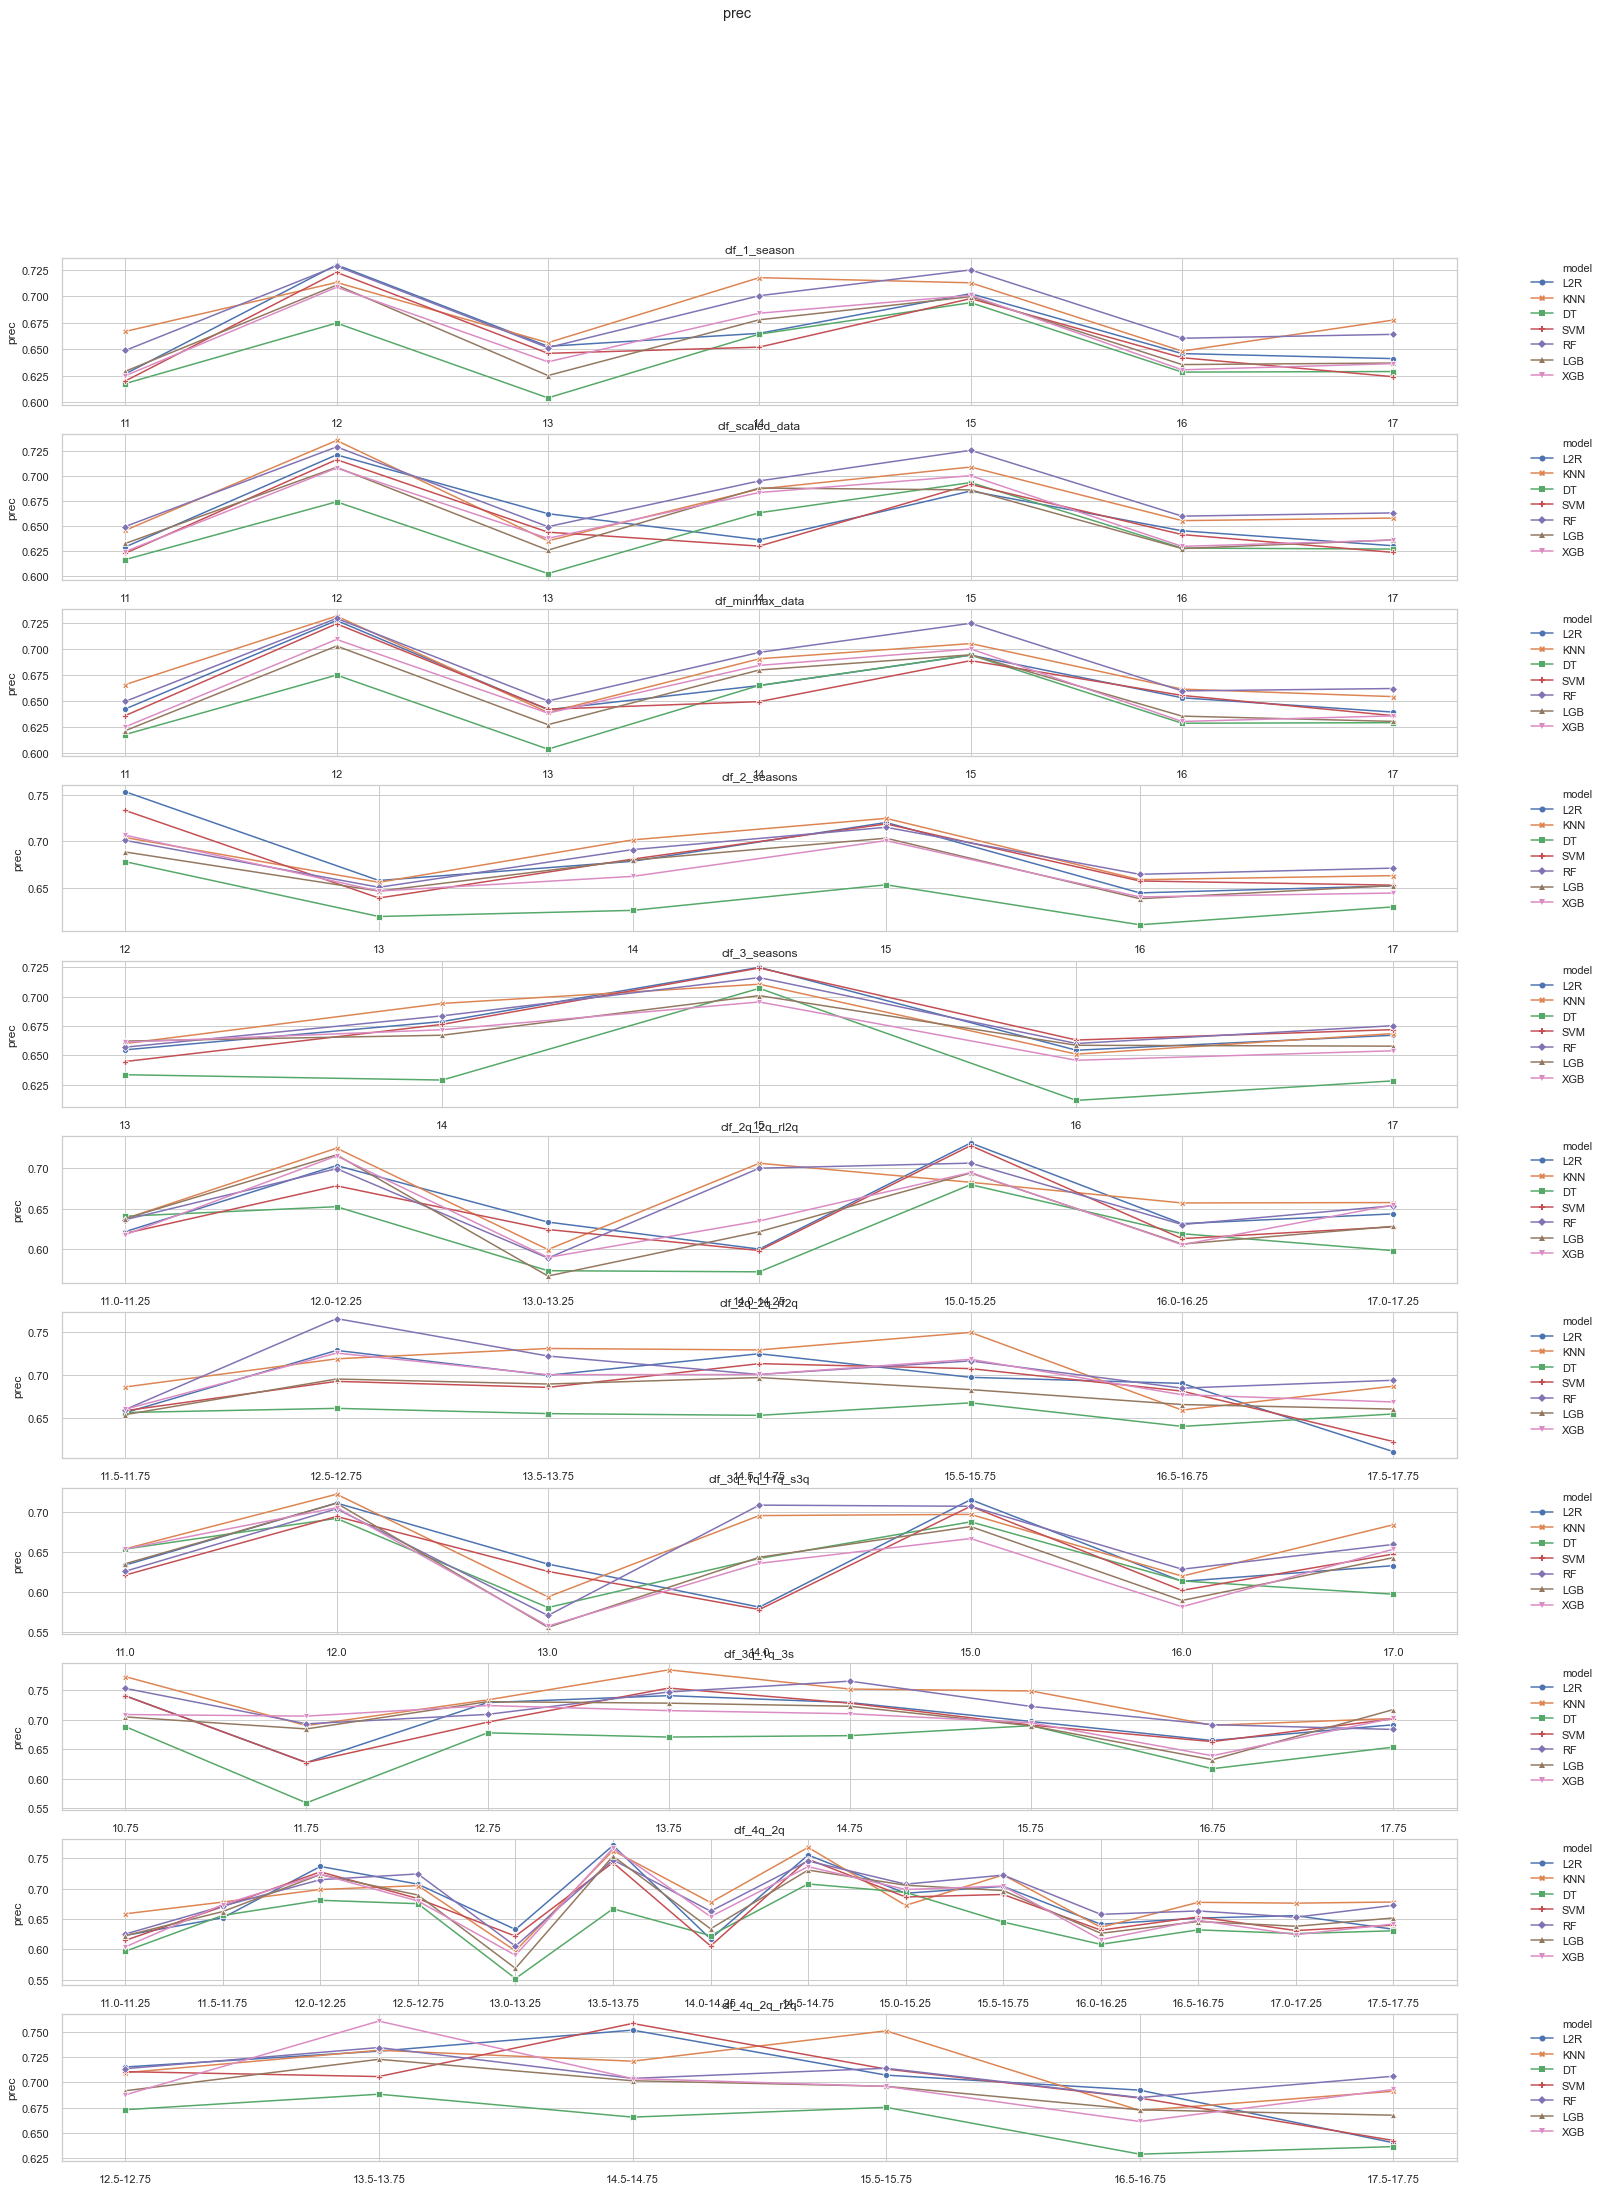

In [97]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

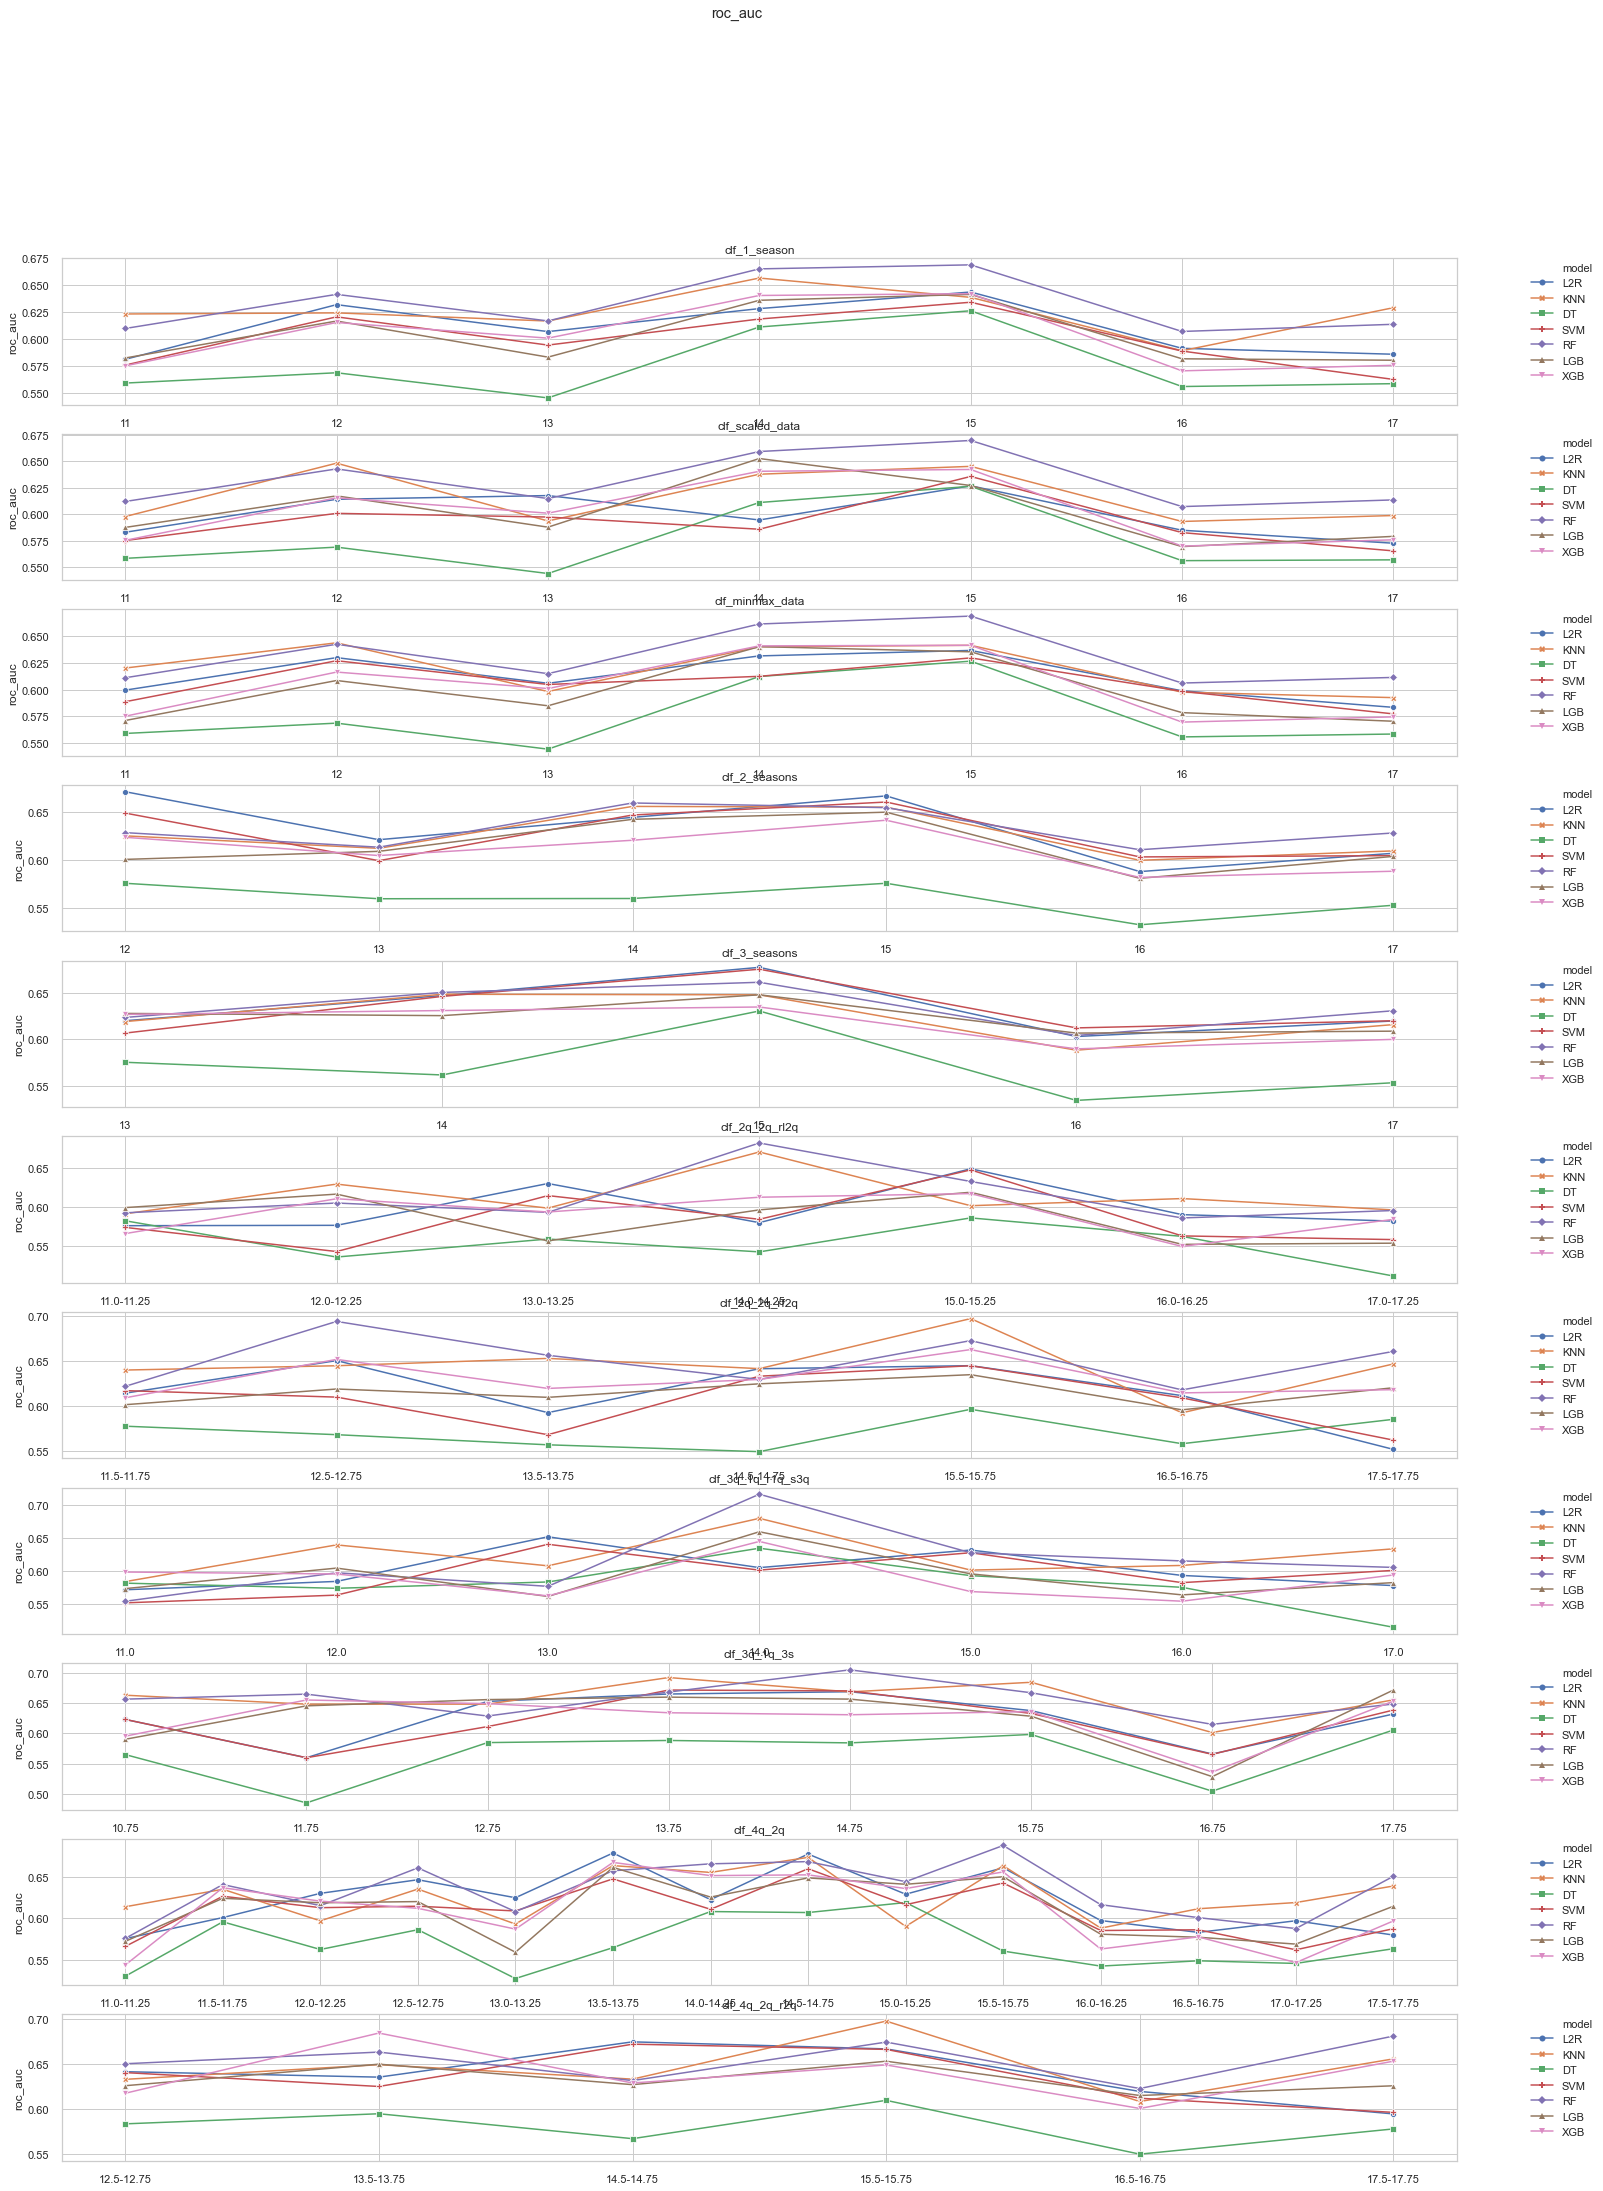

In [98]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)